In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import time
from torch_geometric.data import Data,DataLoader
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx
from torchsummary import summary

if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using GPU device: GeForce RTX 2080 Ti


In [85]:
from torch_geometric.utils import grid
import time
import torch_geometric.transforms as T

def load_and_transform(train_batch, test_batch, dataset):
    start1 = time.time()
    if dataset=='mnist':
        mnist_train=datasets.MNIST('data', download=True, train=True)
        train_X=mnist_train.train_data/256
        train_y=mnist_train.targets
        mnist_test=datasets.MNIST('data', download=True, train=False)
        test_X=mnist_test.test_data/256
        test_y=mnist_test.targets
        N=28
        in_channel=1
        g=grid(N,N)
        
    if dataset=='cifar':
        cifar_train = datasets.CIFAR10('data',  train=True, download=True)
        train_X= torch.tensor(cifar_train.data/256)
        train_y=torch.tensor(cifar_train.targets)
        cifar_test = datasets.CIFAR10('data', train=False,download=True)
        test_X=torch.tensor(cifar_test.data/256)
        test_y=torch.tensor(cifar_test.targets)
        N=32
        in_channel=3
        g=grid(N,N)
            
    train_list =[]
    test_list=[]
    train_size=train_X.size(0)
    test_size=test_X.size(0)
    transform = T.Cartesian(cat=False)
    for i in range(train_size):
        train_list.append(transform(Data(x=train_X[i].view(N*N,in_channel).float(),y=train_y[i], edge_index=g[0],pos=g[1])))
        if i<test_size:
            test_list.append(transform(Data(x=test_X[i].view(N*N,in_channel).float(),y=test_y[i], edge_index=g[0],pos=g[1])))
    
    train_loader = DataLoader(train_list, batch_size=train_batch)
    test_loader = DataLoader(test_list, batch_size=test_batch)
    end1 = time.time()
    print("loading time: "+ str(end1 - start1))
    return train_loader, test_loader

In [86]:
train_mnist, test_mnist=load_and_transform(100, 100, 'mnist')

/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


loading time: 42.05930495262146


In [132]:
from torch_geometric.nn import SplineConv
import torch.nn.functional as F

class Spline(torch.nn.Module):
    def __init__(self,in_c,N):
        super().__init__()
        self.conv1 = SplineConv(in_c, 10, dim=2, kernel_size=5)
        self.fc1 = torch.nn.Linear(N*N*10, 10)
        self.N = N

    def forward(self, data):
        x=data.x
        x = F.relu(self.conv1(x, data.edge_index, data.edge_attr))
        x=x.view(100,self.N*self.N*10)
        x =self.fc1(x)
        return x

In [88]:
def accuracy(pred, target):
        pred=pred.max(axis=1)[1]
        corrects = 100.0 *torch.eq(pred, target).sum().float() / len(target)
        return corrects.item()

In [89]:
def training_loop(EPOCHS, MODEL, OPTIMIZER, device, train_loader, test_loader):
    summary(MODEL)
    
    if torch.cuda.is_available() is False:
        raise Exception("GPU device not found, runtime environment should be set to GPU")
    print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': [], 'epoch_loss':
              [], 'epoch_accuracy':[],'time':None}
    
   
    for epoch in range(EPOCHS):
        start=time.time()
        train_loss = []
        train_acc = []
        test_loss = 0
        test_acc = 0
        for step, data in enumerate(train_loader):
            data.to(device)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out = MODEL(data) # Perform a single forward pass.
            loss = criterion(y_out, data.y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            train_loss.append(loss.detach().item())
            train_acc.append(accuracy(y_out, data.y))
            
        epoch_loss=sum(train_loss)/(step+1)
        epoch_acc=sum(train_acc)/(step+1)
        
        for step,data in enumerate(test_loader):
            data.to(device)
            y_out =MODEL(data)
            loss = criterion(y_out,  data.y) 
            test_loss += loss.detach().item()
            test_acc += accuracy(y_out, data.y)
        test_loss = test_loss / (step+1)
        test_acc = test_acc / (step+1)
        end=time.time()
        print(f"Epoch: {epoch} | Train loss: {epoch_loss} | Train accuracy: {epoch_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_acc)
        history['time']=end-start
    return history

In [133]:
#Spline
device = torch.cuda.current_device()
MODEL_Spline=Spline(1,28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Spline.parameters(), lr=0.03)   
EPOCHS = 1

Spline_history = training_loop(EPOCHS, MODEL_Spline, OPTIMIZER, device,train_mnist, test_mnist )

Layer (type:depth-idx)                   Param #
├─SplineConv: 1-1                        270
├─Linear: 1-2                            78,410
Total params: 78,680
Trainable params: 78,680
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 0.3469464517516705 | Train accuracy: 90.0  | Test loss: 0.21905856162309648 | Test accuracy: 93.43| Time: 16.02563166618347


In [128]:
from torch_geometric.nn import ChebConv
class Cheb(nn.Module):
    def __init__(self, in_channel,K,hidden, size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        self.layers = [self.conv1]
        
        self.history= None
        
    def forward(self, data):
        for layer in self.layers:
            h =  layer(data.x, data.edge_index)
            h = self.relu(h)
        h = h.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h

In [129]:
#Cheb
MODEL_Cheb1=Cheb(in_channel=1,K=25,hidden=10, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cheb1.parameters(), lr=0.03)   
EPOCHS = 1

Cheb1_history = training_loop(EPOCHS, MODEL_Cheb1, OPTIMIZER, device,train_mnist, test_mnist)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 0.3877429677468414 | Train accuracy: 91.38333333333334  | Test loss: 0.16685547912027687 | Test accuracy: 95.05| Time: 21.31631302833557


In [57]:
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_mean_pool
class Cheb2(nn.Module):
    def __init__(self, in_channel,K,size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,10,K)
        self.conv2 = ChebConv(10,10,K)
        self.relu = nn.ReLU()
        self.size = size
        self.layers = [self.conv1,self.conv2]
        self.dense1 = nn.Linear(10,10)
        
        
    def forward(self, data):
        h=data.x
        for layer in self.layers:
            h =  layer(h, data.edge_index)
            h = self.relu(h)
        h = global_mean_pool(h, data.batch)
        h =self.dense1(h)
        return h


In [58]:
#Cheb_random_testing
MODEL_Chebx2=Cheb2(in_channel=1,K=25, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Chebx2.parameters(), lr=0.03)   
EPOCHS = 20

Chebx2_history = training_loop(EPOCHS, MODEL_Chebx2, OPTIMIZER, device,train_mnist, test_mnist)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─ChebConv: 1-2                          2,510
├─ReLU: 1-3                              --
├─Linear: 1-4                            110
Total params: 2,880
Trainable params: 2,880
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 1.0 | Train accuracy: 65.8  | Test loss: 0.5646142089366912 | Test accuracy: 81.93| Time: 39.88478899002075
Epoch: 1 | Train loss: 0.49 | Train accuracy: 84.27  | Test loss: 0.4271447626873851 | Test accuracy: 86.48| Time: 37.165245056152344
Epoch: 2 | Train loss: 0.4 | Train accuracy: 87.48  | Test loss: 0.4104521518945694 | Test accuracy: 87.48| Time: 36.44048523902893
Epoch: 3 | Train loss: 0.35 | Train accuracy: 88.91  | Test loss: 0.3919187689386308 | Test accuracy: 87.96| Time: 35.43341112136841
Epoch: 4 | Train loss: 0.33 | Train accuracy: 89.75  | Test loss: 0.3592398113012314 | Test accuracy: 88.52| Time: 34.590500831604004


KeyboardInterrupt: 

In [46]:
#Cheb_random_testing2
MODEL_Cheb=Cheb2(in_channel=1,K=25, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cheb.parameters(), lr=0.03)   
EPOCHS = 20

Cheb_history = training_loop(EPOCHS, MODEL_Cheb, OPTIMIZER, device,train_mnist, test_mnist)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          520
├─ReLU: 1-2                              --
├─Linear: 1-3                            210
Total params: 730
Trainable params: 730
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 1.35 | Train accuracy: 55.26  | Test loss: 0.9642579475045204 | Test accuracy: 69.78| Time: 21.98755168914795
Epoch: 1 | Train loss: 0.9 | Train accuracy: 71.76  | Test loss: 0.8134560951590538 | Test accuracy: 74.77| Time: 21.944063425064087
Epoch: 2 | Train loss: 0.78 | Train accuracy: 75.54  | Test loss: 0.7314741858839988 | Test accuracy: 77.29| Time: 21.848140478134155
Epoch: 3 | Train loss: 0.72 | Train accuracy: 77.63  | Test loss: 0.6734388938546181 | Test accuracy: 78.74| Time: 21.096149682998657
Epoch: 4 | Train loss: 0.66 | Train accuracy: 79.32  | Test loss: 0.6329854953289032 | Test accuracy: 80.0| Time: 19.284045219421387
Epoch: 5 | Train loss: 0.62 | Train accuracy: 80

In [64]:
from torch_geometric.nn import BatchNorm
from torch_geometric.nn import ARMAConv
class ARMA(nn.Module):
    def __init__(self, in_channel,hidden, K,N, size):
        super().__init__()
        self.conv1 = ARMAConv(in_channel,hidden,num_stacks=K, num_layers=N)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        self.layers = self.conv1
        
        self.history= None
        
    def forward(self,data):
        h=data.x
        h = self.conv1(h, data.edge_index)
        h = self.relu(h)
        h = h.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h

In [135]:
MODEL_ARMA=ARMA(in_channel=1,K=3,N=3, hidden=10, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_ARMA.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 1

ARMA_history = training_loop(EPOCHS, MODEL_ARMA, OPTIMIZER, device,train_mnist, test_mnist)

Layer (type:depth-idx)                   Param #
├─ARMAConv: 1-1                          810
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 79,220
Trainable params: 79,220
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 0.3862850239997109 | Train accuracy: 89.08333333333333  | Test loss: 0.3430699599534273 | Test accuracy: 89.92| Time: 27.40825057029724


In [144]:
C_acc=np.array(Cheb1_history['train_accuracy'][0])[::10]
A_acc=np.array(ARMA_history['train_accuracy'][0])[::10]
S_acc=np.array(Spline_history['train_accuracy'][0])[::10]
C_loss=np.array(Cheb1_history['train_loss'][0])[::10]
A_loss=np.array(ARMA_history['train_loss'][0])[::10]
S_loss=np.array(Spline_history['train_loss'][0])[::10]

Text(0.5, 0, 'Batches')

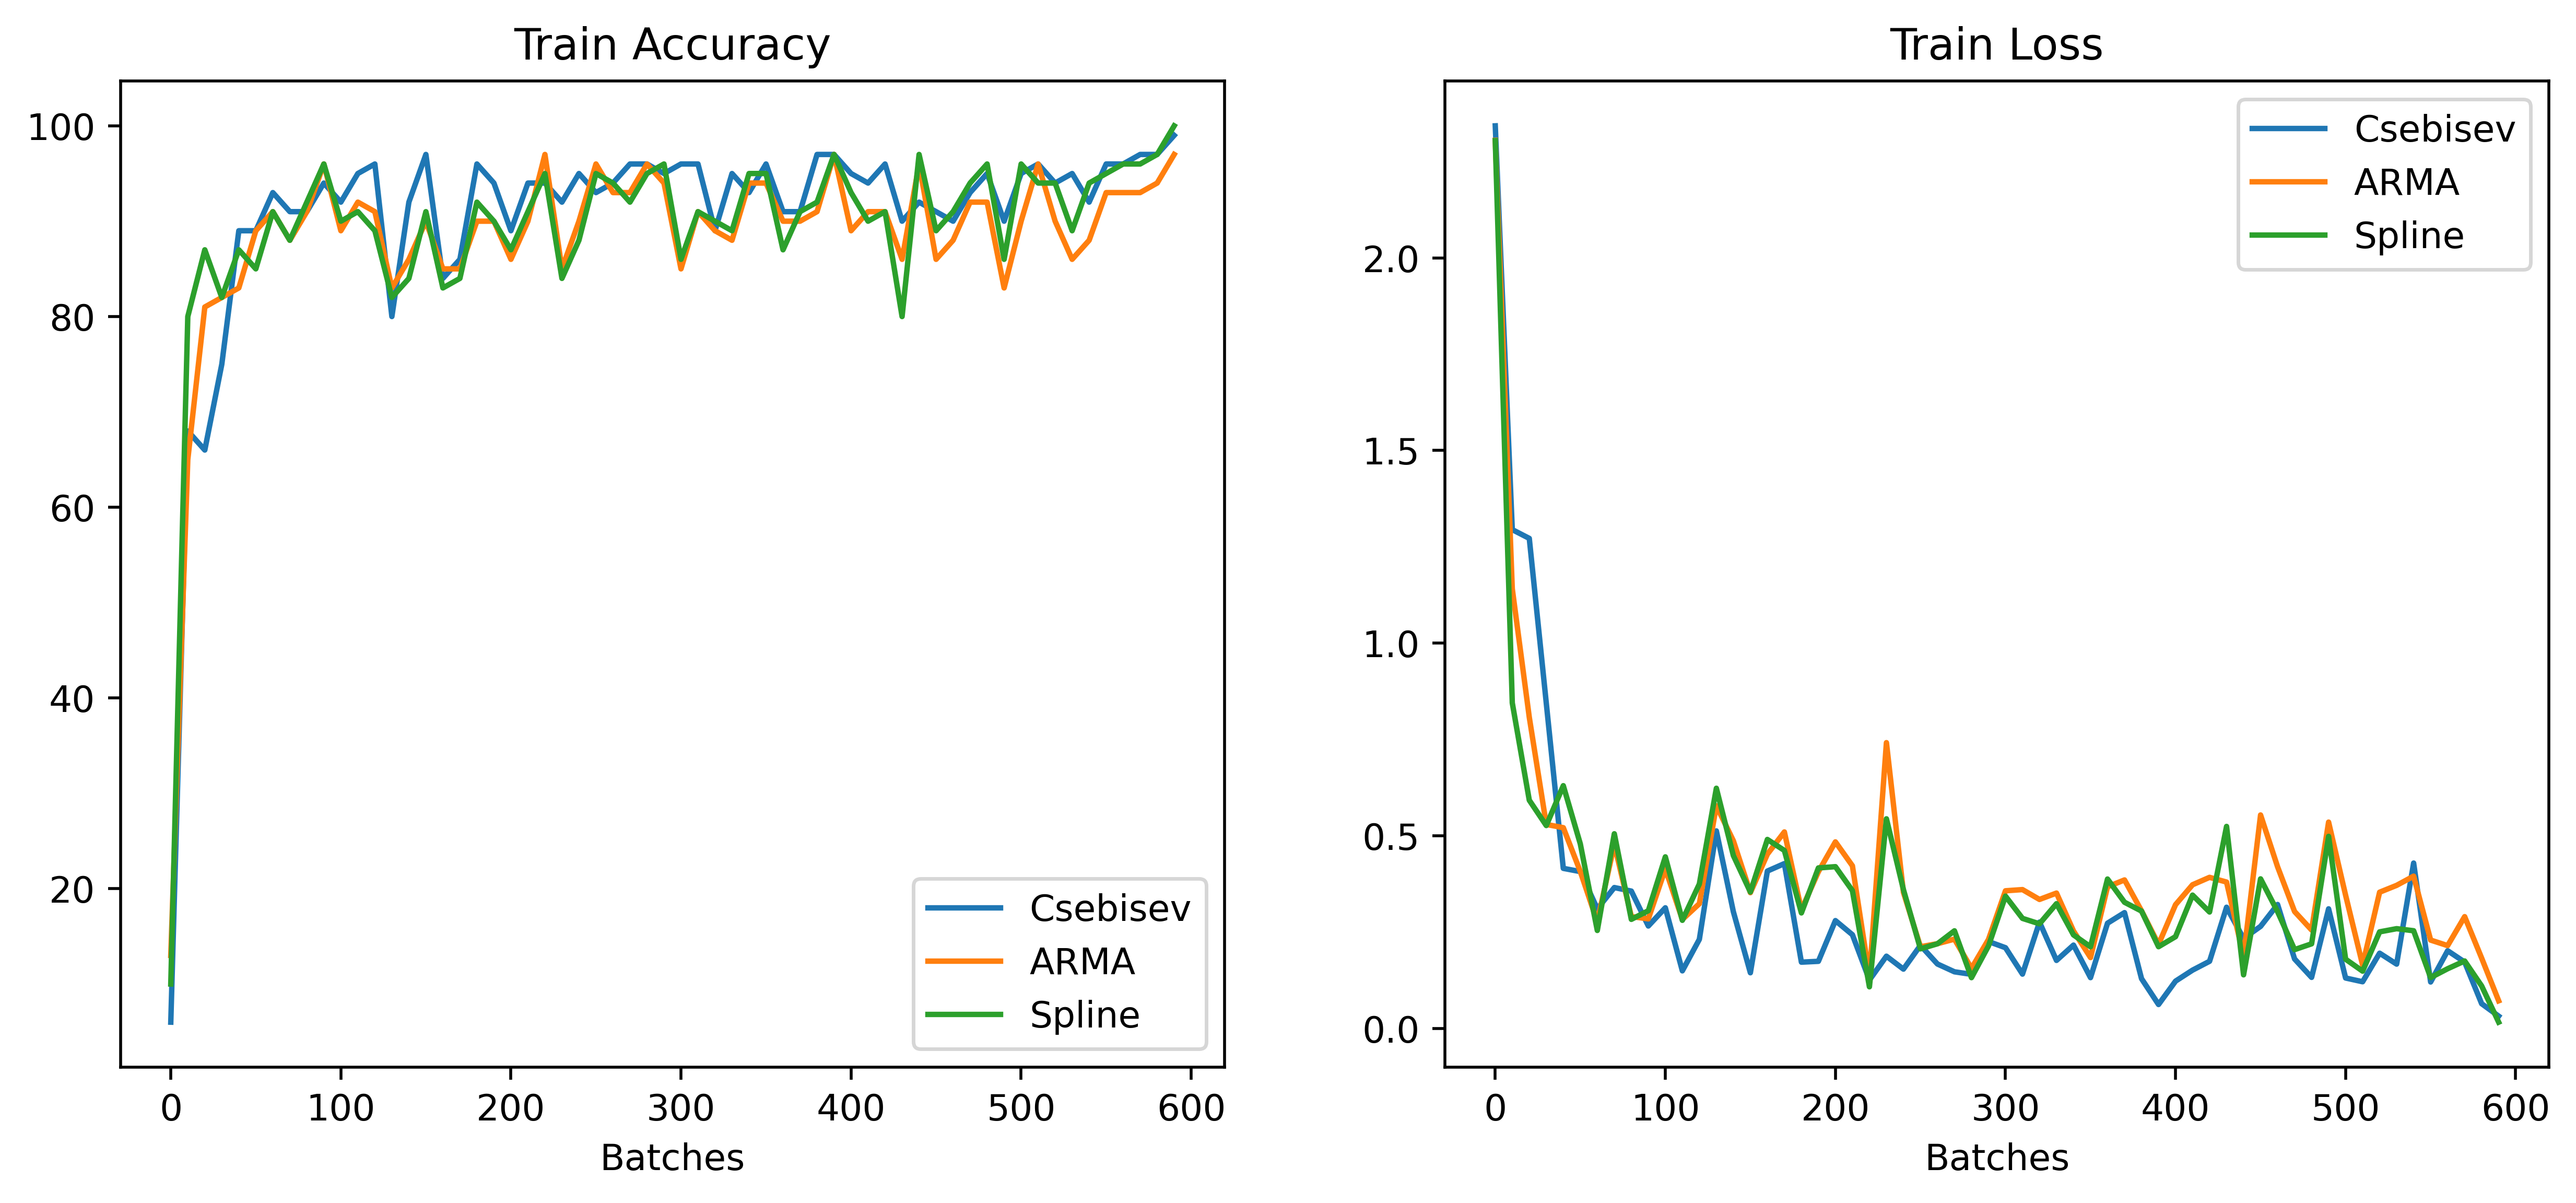

In [158]:
l=60
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5),dpi=500)
ax1.plot(np.arange(l)*10,C_acc,label='Csebisev')
ax1.plot(np.arange(l)*10,A_acc,label='ARMA')
ax1.plot(np.arange(l)*10,S_acc,label='Spline')
#ax1.set_xticklabels()
ax1.legend(loc=4)
ax1.set_title('Train Accuracy')
ax1.set_xlabel('Batches')
ax2.plot(np.arange(l)*10,C_loss,label='Csebisev')
ax2.plot(np.arange(l)*10,A_loss,label='ARMA')
ax2.plot(np.arange(l)*10,S_loss,label='Spline')
ax2.legend(loc=1)
ax2.set_title('Train Loss')
ax2.set_xlabel('Batches')

In [147]:
print(Cheb1_history['test_accuracy'],ARMA_history['test_accuracy'],Spline_history['test_accuracy'])

[95.05] [89.92] [93.43]
